# Triball: a benchmark for rigid bodies in contact.

This test simulates a rigid body that is in contact with the ground plane and verifies the contact forces experienced at each contact point.

The model consists of three solid spheres connected by rods in a triangular configuration. This benchmark varies both triball configurations as well as the velocity of the center of mass(com). 
The model doesn't consist of any joints.

Two scenarios have been chosen to validate the simulated solutions and to represent simple and complex scenarios.

In **simple** scenario the triball model is at rest and no external is applied except 
gravitational and contact forces, here the test parameter being the configuration in which balls are arranged (eg: equilateral or isosceles triangle).
The normal/contact force experience at the contact point is a function of triball configuration, which forces can be computed analytically 
and can be used to compare against the simulated/ numerical solution.

In **complex** scenario the triball model has been given a specific initial velocity (both linear and angular). Possible metric for comparision here can be checking if total energy exceeds inital energy at t=0 and difference between friction cone and pyramid model.

## Simple scenario

As the rigid body is at rest. The forces experienced by it are a contact forces and gravitational force in the downward direction. In an equilibrium state, any rigid body should have a zero net force and torque about any point.

![triball_static_case](img/triball/triball_static.jpg)

## Complex scenario
As the rigid body is given a specific initial velocity, friction forces will be acting in the tangential plane to the normal force at each contact point. Energy conservation, checking frcition force direction and magnitude, and comparing difference in states between cone vs pryramid models can use a possible metrics.

## Definition of coordinate frames and variable

![triball_diagram](https://github.com/yaswanth1701/simulation_benchmark/assets/92177410/1b2589e8-efb3-4885-801f-0d9912178565)

Consider an inertial frame $O$ and a rigid body with a coordinate frame $c$ attached at the center of mass:

- The position of the center of gravity (cg) in $O$  is given by  **c**.
- The orientation of $c$ with respect to $O$ is given by the quaternion **$q$**.
- A rotation matrix from $O$ to $c$ : $R(q)$ 
- Angular velocity in frame $c$ : $\omega$
- Three contact points for the model are expressed in frame $O$ as $C_a$, $C_b$ and $C_c$.
- The three contact force are denoted as $N_a$, $N_b$ and $N_c$ and are expressed in the $O$ frame
  
Rigid body has the following inertial parameters:
- Total mass *m*
- inertia matrix $I$ expressed in $c$
- Density of model be $\rho$
- Radius of ball/sphere is denoted as $R_s=0.02$.
- Radius of rod/cylinder is denoted as $R_c=0.005$.
- Mass of each ball and rod is $m_s$ and $m_c$ respectively.

### Solution for simple scenario:

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym

### Geometric variables:

- For simplifying the configuration of balls, we assume the coordinates of
  <br> ball $A$ (shown in the above figure) and the altitude of the triangle 
  $AD$ <br> are fixed throughout the test cases.
- The variables are angles $\angle BAD$ ($\theta _1$) and $\angle CAD$ ($\theta _2$).
- The height of the altitude be $h$ and the length from origin $O$ to point D be $k$.
- Then coordinate of ball $A$ will be $P_a(h - k, 0, 0.02)$
- Coordinates of ball $B$ will be $P_b(-k, h*tan\theta _1, 0.02)$.
- Coordinates of ball $C$ will be $P_c(-k, -h*tan\theta _2, 0.02)$.
- Further coordinates of center of mass (com) of each rod is denoted by $P_{ab}$, $P_{bc}$, $P_{ca}$.


In [47]:
rho = 200
r_c = 0.005
r_s = 0.02
# total ten pair of angles theta_1 and theta_2
N = 10

# volume of sphere
v_s = (4*np.pi*r_s**3)/3
m_s = rho*v_s

#altittude height (m)
h = 0.15
k = 0.05

theta_1 = np.linspace(np.pi/6, np.pi/2, N, endpoint=False)
theta_2 = np.linspace(np.pi/6, np.pi/3, N)

# coordinates of ball A
p_a = np.repeat(np.array([[h - k , 0, 0.02]]), N, axis=0)

# coordinates of ball B 
p_b_x = np.ones((N,1)) * -k
p_b_y = h*np.tan(theta_1).reshape(N,1)
p_b_z = np.ones((N,1)) * 0.02
p_b = np.hstack((p_b_x, p_b_y, p_b_z))

# coordinates of ball C
p_c_x = np.ones((N,1)) * -k
p_c_y = - h*np.tan(theta_2).reshape(N,1)
p_c_z = np.ones((N,1)) * 0.02
p_c = np.hstack((p_c_x, p_c_y, p_c_z))

As the body is at rest the net force and moment about any point should be zeros. We choose to calculate the net moment about point $P_a$.

- Force balance gives:
  
   $N_a = [0, 0, n_a]^T, \text{ } N_b = [0, 0, n_b]^T \text{ and } N_c = [0, 0, n_c]^T$ 
    
   $g = [0, 0, -9.8]^T$ 
    
   $F_{net}= ma$
  
   $a = 0$
  
   $N_a + N_b + N_c + g = 0$ -> $n_a + n_b + n_c = 9.8$ ---- $equation1$
   
   $\tau _a = 0$
  
   $m_c*g \times (P_{ab} - P_a)$ + $(m_s *g + N_b) \times (P_b - P_a)$ +
   $m_c *g \times (P_{bc} - P_a)$ +

   $(m_s *g + N_c) \times (P_c - P_a)$ + $m_c *g \times (P_{ca} - P_a)$ = 0 ----- $equation2 \text{ and } 3$
   
So, we get a total of three linear equations to solve for $n_a$, $n_b$, and $n_c$.

In [48]:
def hat(v):
    # hat operator for vector
    v = v.ravel()
    return np.array([[0, v[2], -v[1]],
                     [-v[2], 0, v[0]],
                     [v[1], -v[0], 0]])

In [52]:
def compute_contact_forces(p_a, p_b, p_c):
    # creating symbolic variables for normal forces
    n_a = sym.symbols("n_a")
    n_b = sym.symbols("n_b")
    n_c = sym.symbols("n_c")
    
    com = (p_a + p_b + p_c)/3
    
    # contact force at each contact point
    N_a = np.array([0, 0, n_a]).reshape(3,1)
    N_b = np.array([0, 0, n_b]).reshape(3,1)
    N_c = np.array([0, 0, n_c]).reshape(3,1)

    # length of each rod
    l_ab = np.linalg.norm(p_b - p_a)
    l_bc = np.linalg.norm(p_c - p_b)
    l_ca = np.linalg.norm(p_a - p_c)
    
    #mass of each rod
    m_c1 = np.pi*(r_c**2)*l_ab*rho
    m_c2 = np.pi*(r_c**2)*l_bc*rho
    m_c3 = np.pi*(r_c**2)*l_ca*rho

    # com of rod AB
    p_ab = (p_a + p_b)/2
    
    # com of rod BC
    p_bc = (p_b + p_c)/2
    
    # com of rod CA
    p_ca = (p_c + p_a)/2
    g = np.array([0,0,-9.8]).reshape(3,1)

    # force balance 
    eq_f = N_a + N_b + N_c + (3*m_s + m_c1 + m_c2 + m_c3)*g

    # z direction force balance
    eq1 = eq_f[2][0]
    
    # moment balance about A
    eq_t = hat(p_ab - p_a) @ (m_c1 * g) + hat(p_b - p_a) @ (m_s * g + N_b) +\
         hat(p_bc - p_a) @ (m_c2 * g) + hat(p_c - p_a) @ (m_s *g + N_c) +\
         hat(p_ca - p_a) @ (m_c3 * g)
    
    eq2 = eq_t[0][0]
    eq3 = eq_t[1][0]

    result = sym.linsolve([eq1, eq2, eq3], (n_a, n_b, n_c))

    return list(result.args)


In [57]:
normal_forces = np.zeros((N,3))
for i in range(N):
    normal_force = compute_contact_forces(p_a[i,:], p_b[i,:], p_c[i,:])
    normal_forces[i, :] = normal_force[0]

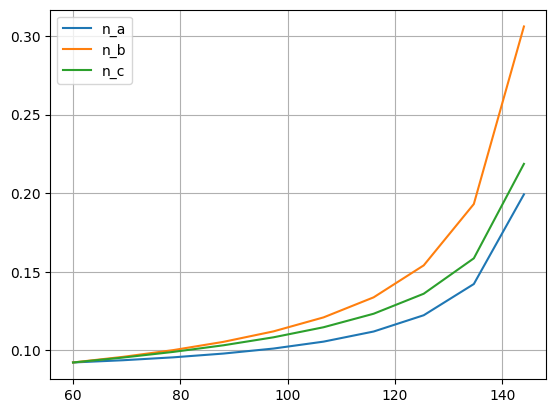

In [64]:
theta = np.rad2deg(theta_1 + theta_2)
plt.plot(theta, normal_forces, label=["n_a", "n_b", "n_c"])
plt.legend()
plt.show()

### Solution for complex case scenario

  <img src="img/triball/triball_friction_cone.gif" width="395" height="240" />
  <img src="img/triball/triball_friction_pyramid.gif" width="395" height="240" />



**First image is friction cone model and second image is friction pyramid model.**

##### **Energy conservation**

- Kinetic energy of model: $T(t) = \frac{1}{2} m \dot c(t)^T \dot c(t) + \frac{1}{2} I \omega(t)^T \omega(t)$ 
- Potential energy of model: $V(t) = -mg^Tc(t)$
- Total energy of model: $E(t) = T(t) + V(t)$
- Intial totaltotal energy of model: $E(t_0)$
- Total energy of model at time $t>0$ $E(t)$
- As friction force is dissipative force: $E(t_0) > E(t) => E(t_0) - E(t) > 0$

##### **Friction is dissipative force**

- Location of any point in $c$ frame: $r_c$.
- Slip velocity of any point on model in $O$ frame: $ \dot c_p(t) = \dot c(t) + \omega(t) \times r_c$.
- Unit vector along the direction of slip velocity: $ \hat{\dot{c_p}}(t) =  \frac {\dot c_p(t)}{\| \dot c_p(t) \|}$.
- For contact points $A, B$, and $C$ unit vector along the direction of their velocity: $ \hat{\dot{c_a}}, \hat{\dot{c_b}}$ and $\hat{\dot{c_c}}$.
- Contact forces at contact points in $O$ frame : $f$.
- Unit vector along the contact force in $O$ frame: $\hat f$.
- As the velocity of ball is in $xy$ plane, the friction forces should opposite in direction to slip velocity: $f \cdot \dot c_p <=0$.

##### **Magnitude of friction force**
- Unit normal at contact point: $\hat n$
- Contact force along contact normal: $ (f \cdot \hat n) \hat n$
- Unit vector along first friction direction in $c$ frame: $ fdir_1$
- Friction force along first friction direction expressed in $O$ frame: $R^T(q) (\mu _1 \| f \cdot \hat n \| * fdir_1)$ 
- Unit vector along second friction direction in $c$ frame: $ fdir_2$
- Friction force along second friction direction expressed in $O$ frame: $R^T(q) (\mu _2 \| f \cdot \hat n \| * fdir_2)$ 

##### **Friction cone model (fcm) vs pyramid model (fpm) (ODE only)**

- Difference in cog position in $O$ frame:  $ \| c_{fcm}(t) - c_{fpm}(t) \|$
- Difference in cog velocity in $O$ frame: $ \| \dot c_{fcm}(t) - \dot c_{fpm}(t) \|$
- Difference in cog acceleration in $O$ frame: $ \| \ddot c_{fcm}(t) - \ddot c_{fpm}(t) \|$

## Inputs, Outputs, and Metrics

### Inputs
This benchmark generates tests of different parameters based on these inputs:

Parameter                    | Type    | Description
---------------------------- | ------- | -----------
Physics engine               | string  | `ode`, `bullet`, `simbody`, or `dart`
Face angle                   | double  | units in radians
Friction model               | string  | pyramid or cone (ode only)
Surface slope                | Double  | units of radians
Simple or Complex scenario   | Boolean |
Centre of gravity height     | Double  | unit of meters expressed in link frame
Equal kinetic energies       | Boolean | 

### Metrics
These errors are measured and saved:

Metric                 | Type     | Description
-----------------------| -------- | -----------
Contact force error     | 3-vector | units of Newton(N)
Friction direction error  | 3-vector |
Fricion magnitude error | 2-vector| units of Newton(N)
Linear velocity error | 3-vector | units of meters / second
position error | 3-vector | units of meters
Energy error           | double   | units of J

### Additional outputs
In addition, computation time is measured, by saving these quantities as outputs:

Metric                 | Type   | Description
-----------------------| ------ | -----------
Duration in wall time  | double | units of seconds
Duration in sim time   | double | units of seconds
Duration ratio         | double | wall duration divided by sim duration